1. Setup and Load Data

1.1 Install Dependencies and Setup

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [433]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt

In [434]:
#Limit GPU consumption

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

1.2 Load Data

In [435]:
data_dir = 'Eye_diseases'

In [436]:
os.listdir(data_dir)

['Cataracts', 'Jaundice', 'Normal', 'Uveitis']

In [437]:
#Accesses the folder where my images are being kept in 4 folders labelled by their conditions.

data = tf.keras.utils.image_dataset_from_directory('Eye_diseases').repeat(20)

Found 217 files belonging to 4 classes.


In [438]:
#Allows me to loop through the newly created dataset

data_iterator = data.as_numpy_iterator()

In [439]:
#Creates a batch of 32 images that I can pull from the iterator

batch = data_iterator.next()

In [440]:
#Shows that I have 32 images in the batch that are 256 x 256 pixels and in color

batch[0].shape

(32, 256, 256, 3)

In [441]:
#My labels

batch[1]

array([3, 2, 0, 2, 0, 0, 1, 2, 1, 2, 1, 3, 3, 0, 3, 2, 2, 0, 0, 2, 2, 2,
       1, 0, 2, 3, 2, 3, 2, 2, 0, 2])

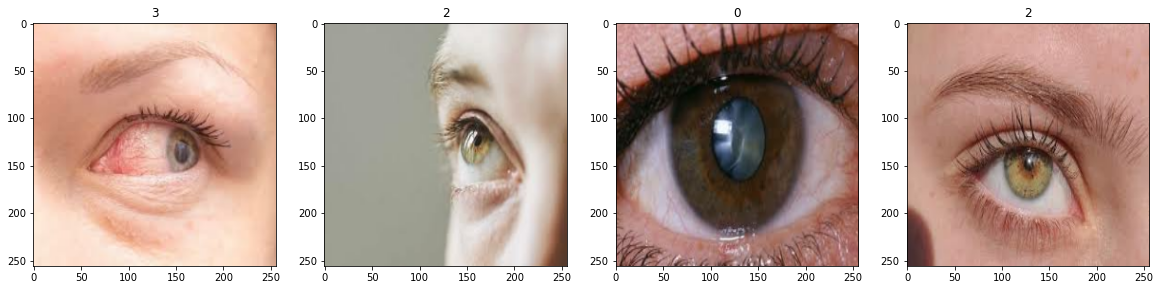

In [442]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

CLASSES:
0 = Cataract,
1 = Jaundice,
2 = Normal,
3 = Uveitis

1.3 Mirror Each Uniform Image to Double the Data

In [443]:
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation

preprocessing_layer = tf.keras.layers.RandomFlip(mode='horizontal', seed =None)
preprocessing_rotation_layer = tf.keras.layers.RandomRotation(0.05)

data = data.map(lambda x, y: (preprocessing_layer(x), y))
data = data.map(lambda x, y: (preprocessing_rotation_layer(x), y))

1.4 Scale the Data

In [444]:
data = data.map(lambda x,y: (x/255, y))

In [445]:
scaled_iterator = data.as_numpy_iterator()

In [446]:
batch = scaled_iterator.next()

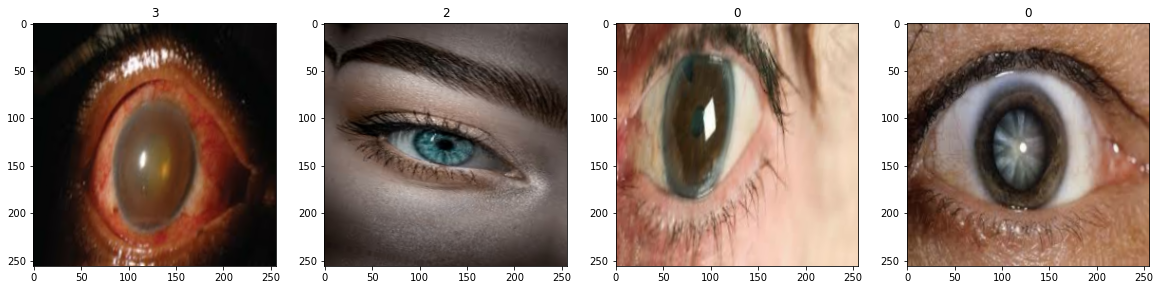

In [447]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

1.5 Split the Data

In [448]:
#We have a total of 7 batches of data with 32 images per batch (224 images total)

len(data)

140

In [449]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [450]:
print("Number of batches in training:", train_size)
print("Number of batches in validation:", val_size)
print("Number of batches in test:", test_size)

Number of batches in training: 98
Number of batches in validation: 29
Number of batches in test: 15


In [451]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

2. Deep Learning Model

2.1 Build the model

In [452]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [453]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [454]:
#Create the model

model = Sequential()

In [455]:
#Add layers to the model

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))     #Convolutional layer 1, input layer with 16 filters as 3x3 pixels in 1 stride
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))                              #Convolutional layer 2 with 32 filters
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))                              #Convolutional layer 3 with 16 filters
model.add(MaxPooling2D())

model.add(Flatten())                                                            #Flatten layer

model.add(Dense(256, activation='relu'))                                        #Dense layer 1
model.add(Dense(1, activation='sigmoid'))                                       #Dense layer 2 with sigmoid function applied with single output

In [456]:
model.compile('adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [457]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 14400)           

2.2 Train the model

In [458]:
#Create a log directory

logdir = 'C:\Logs'

In [459]:
#Create a callback

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [460]:
#Fit the model

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
98/98 [==============================] - 96s 972ms/step - loss: 0.0000e+00 - accuracy: 0.1215 - val_loss: 0.0000e+00 - val_accuracy: 0.1178
Epoch 2/20
98/98 [==============================] - 94s 957ms/step - loss: 0.0000e+00 - accuracy: 0.1198 - val_loss: 0.0000e+00 - val_accuracy: 0.1189
Epoch 3/20
98/98 [==============================] - 93s 948ms/step - loss: 0.0000e+00 - accuracy: 0.1198 - val_loss: 0.0000e+00 - val_accuracy: 0.1167
Epoch 4/20
98/98 [==============================] - 92s 936ms/step - loss: 0.0000e+00 - accuracy: 0.1198 - val_loss: 0.0000e+00 - val_accuracy: 0.1189
Epoch 5/20
98/98 [==============================] - 93s 946ms/step - loss: 0.0000e+00 - accuracy: 0.1198 - val_loss: 0.0000e+00 - val_accuracy: 0.1178
Epoch 6/20
98/98 [==============================] - 91s 930ms/step - loss: 0.0000e+00 - accuracy: 0.1198 - val_loss: 0.0000e+00 - val_accuracy: 0.1222
Epoch 7/20
98/98 [==============================] - 91s 932ms/step - loss: 0.0000e+00 - accura

3. Evaluation

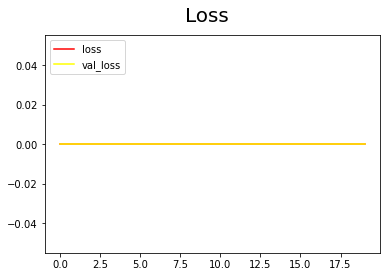

In [461]:
#Performance

fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='yellow', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

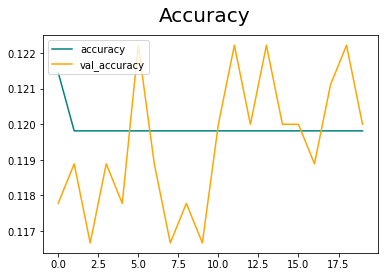

In [462]:
#Accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

4. Test the Model

In [463]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [464]:
#Precision, Recall, and Accuracy functions

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [465]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [466]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.7736318111419678, Recall:1.0, Accuracy:0.1538461595773697


In [467]:
#Confusion Matrix

5. Test

In [468]:
import cv2
import numpy as np

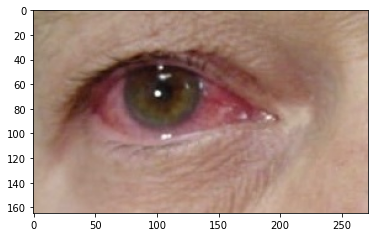

In [469]:
#Load image model has not seen yet.

img = cv2.imread('uvtest.jpeg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_color)
plt.show()

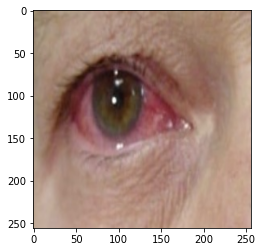

In [470]:
resize = tf.image.resize(img_color, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [471]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [472]:
yhat

array([[1.]], dtype=float32)

CLASSES:
0 = Cataract,
1 = Jaundice,
2 = Normal,
3 = Uveitis

In [473]:
if yhat == 0.0:
    print(f'Predicted class is CATARACT')
    if yhat == 1.0:
        print(f'Predicted class is JAUNDICE')
    if yhat == 2.0:
        print(f'Predicted class is NORMAL')
else:
    print(f'Predicted class is UVEITIS')

Predicted class is UVEITIS


6. Save

In [474]:
#from tensorflow.keras.models import load_model

In [475]:
#model.save(os.path.join('models','imageclassifier.h5'))

In [476]:
#new_model = load_model('imageclassifier.h5')

In [477]:
#new_model.predict(np.expand_dims(resize/255, 0))